In [54]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from googletrans import Translator  # To translate tweets to English
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dodyagung/accident")

print("Path to dataset files:", path)

Path to dataset files: /Users/valencia/.cache/kagglehub/datasets/dodyagung/accident/versions/6


# Pre-processing

### Retrieve and split dataset

In [62]:
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('/Users/valencia/Desktop/vscode_projects/nlp/kagglehub/datasets/dodyagung/accident/versions/6/twitter_label_manual.csv')  # Replace 'your_dataset.csv' with the actual file path

# Separate the data into two groups based on the target
true_data = data[data['is_accident'] == 1]
false_data = data[data['is_accident'] == 0]

print(len(true_data))
print(len(false_data))
print(0.1*(len(data)))

# Split the dataset into features (X) and labels (y)
X = data['full_text']  # The tweet text
y = data['is_accident']  # The labels (1 for True accidents, 0 for False)

X_train_uncleaned, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Training set - True: {sum(y_train == 1)}, False: {sum(y_train == 0)}")
print(f"Test set - True: {sum(y_test == 1)}, False: {sum(y_test == 0)}")

360
642
100.2
Training set - True: 288, False: 513
Test set - True: 72, False: 129


### Remove hyperlinks, emojis, hashtags, mentions

In [64]:
import re


# Function to clean the text
def clean_text(text):
     # Remove hyperlinks
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    # Remove mentions (e.g., @username)
    text = re.sub(r'@\w+', '', text)  # Remove entire mentions including '@'
    # Remove hashtags (e.g., #hashtag)
    text = re.sub(r'#\w+', '', text)  # Remove entire hashtags including '#'
    # Remove emojis and special characters (keeping words and spaces)
    text = re.sub(r'[^\w\s]', '', text)  # Remove everything that is not a word or space
    # Remove numbers (optional)
    text = re.sub(r'\d+', '', text)  # Remove numbers
    # Normalize whitespace (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text.strip()  # Remove leading and trailing whitespace


# Apply the cleaning function to the desired text column (e.g., 'full_text')
train = pd.DataFrame({'preprocessed_text': X_train_uncleaned.apply(clean_text), 'y_train': y_train})


# Display the cleaned text
print(train[['preprocessed_text', 'y_train']].head(20))

                                     preprocessed_text  y_train
846  Hampir tenggelam Pingsan Mimisan Dirawat lebih...        0
625  SEA Games Kapten Thailand Siap Bangkit dan Ang...        0
459  BREAKING NEWS Kecelakaan Maut Dua Pelajar di T...        1
920  Aku juga ikut Terharu saat teman ku mengalami ...        0
216  Yth pak mohon diperhatikan jalur gentong serin...        0
764  tentang seorang wanita bernama Cha Yuri yg men...        0
111  Kecelakaanpembunuhanperampokan ada di sekitark...        0
460  Udah dm an perhatian sayangan jadian Pas mau m...        0
263  Begini Kronologis Seorang Pengendara Motor Tew...        1
446  pas pulang ngampus aku menung dijalan apa coba...        0
746      Ah anjir nyesel berhenti liat yang kecelakaan        0
196                      Kecelakaan Maut Renggut Nyawa        1
78   I think not every epilepsy case is mental illn...        0
537  WIB Cikarang Barat KM KM arah Jakarta PADAT ad...        1
939  Antisipasi Kecelakaan lalulintas pe

### Translate

In [75]:
import pandas as pd
from transformers import pipeline

# Initialize the translation pipeline
translator = pipeline("translation", model="facebook/mbart-large-50-many-to-many-mmt", device=0)

def translate_dataset(data, text_column, src_lang="id_ID", tgt_lang="en_XX"):
    
    # Ensure the specified column exists
    if text_column not in data.columns:
        raise ValueError(f"Column '{text_column}' not found in the DataFrame.")

    # Translate each text entry in the specified column
    data['translated_text'] = data[text_column].apply(lambda x: translator(x, src_lang=src_lang, tgt_lang=tgt_lang)[0]['translation_text'] if isinstance(x, str) else x)
    
    return data

# Translate the specified text column (e.g., 'full_text')
# translated_data = translate_dataset(data, 'cleaned_text')
train = translate_dataset(train, 'preprocessed_text')

# Display the original and translated text
print(train[['preprocessed_text', 'translated_text']].head(10))


                                     preprocessed_text  \
846  Hampir tenggelam Pingsan Mimisan Dirawat lebih...   
625  SEA Games Kapten Thailand Siap Bangkit dan Ang...   
459  BREAKING NEWS Kecelakaan Maut Dua Pelajar di T...   
920  Aku juga ikut Terharu saat teman ku mengalami ...   
216  Yth pak mohon diperhatikan jalur gentong serin...   
764  tentang seorang wanita bernama Cha Yuri yg men...   
111  Kecelakaanpembunuhanperampokan ada di sekitark...   
460  Udah dm an perhatian sayangan jadian Pas mau m...   
263  Begini Kronologis Seorang Pengendara Motor Tew...   
446  pas pulang ngampus aku menung dijalan apa coba...   

                                       translated_text  
846  Almost drowned. Mimisan was in intensive care ...  
625  SEA Games Thailand's captain is on the rise an...  
459  NEWS ANALYSIS Two Students Killed in Sidoarjo ...  
920  I was also shocked when my friend had a stroke...  
216  Yth, sir, please be aware that downhill lots o...  
764  It's about a w

### Clean and translate test data

In [238]:
test = pd.DataFrame({'preprocessed_text': X_test.apply(clean_text), 'y_train': y_test})
test = translate_dataset(test, 'preprocessed_text')


# Model 1: Bert

In [197]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW 
from sklearn.utils import class_weight



# Revised function to load model and tokenizer
def load_model_and_tokenizer(model_name='bert-base-uncased', num_labels=2, load_weights=False):
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    tokenizer = BertTokenizer.from_pretrained(model_name)
    
    if load_weights:
        model.load_state_dict(torch.load('bert_model.pth'))  # Load only if specified
        model.eval()  # Set the model to evaluation mode

    return model, tokenizer

# Encode tweets function remains the same
def encode_tweets(tokenizer, tweets, max_length=128):
    return tokenizer.batch_encode_plus(
        tweets.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

# Create DataLoader function remains the same
def create_data_loader(tokenizer, X, y=None, batch_size=32):
    encoded_inputs = encode_tweets(tokenizer, X)
    input_ids = encoded_inputs['input_ids']
    attention_masks = encoded_inputs['attention_mask']
    
    if y is not None:
        labels = torch.tensor(y.values)
        dataset = TensorDataset(input_ids, attention_masks, labels)
    else:
        dataset = TensorDataset(input_ids, attention_masks)  # No labels for test data

    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Training function remains the same
def train_model(model, train_loader, epochs=3, learning_rate=3e-5):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

    # Save the model after training
    torch.save(model.state_dict(), 'bert_model.pth')



# Main function for training
def train_main(train_data, train_labels):
    model, tokenizer = load_model_and_tokenizer(load_weights=False)  # No weights loaded for training
    train_loader = create_data_loader(tokenizer, train_data, train_labels)  # Create DataLoader for training
    train_model(model, train_loader)  # Train the model


train_main(train['translated_text'], y_train)  # For training



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 0.12824910879135132
Epoch 2/3, Loss: 0.05169098079204559
Epoch 3/3, Loss: 0.02716640569269657


### Model 1: Results

In [239]:


# Prediction function remains the same
def predict(model, test_loader):
    predictions = []
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    with torch.no_grad():  # Disable gradient tracking for evaluation
        for batch in test_loader:
            input_ids, attention_mask = [x.to(device) for x in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)  # Get the predicted class
            predictions.extend(preds.cpu().numpy())  # Store the predictions

    return predictions

# Main function for testing
def test_main(test_data):
    model, tokenizer = load_model_and_tokenizer(load_weights=True)  # Load weights for inference
    test_loader = create_data_loader(tokenizer, test_data)  # Create DataLoader for test data
    predictions = predict(model, test_loader)  # Get predictions
    return predictions


###########################################################################################################################################

y_pred_1 = test_main(test['translated_text'])  # For testing


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/k6/3tf4d74975j0pjkbm28_ct3c0000gn/T/ipykernel_16472/2598642804.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via

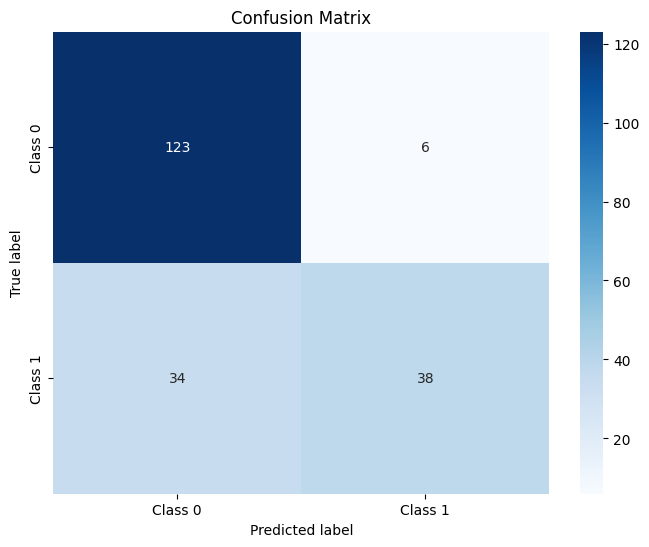

Accuracy: 0.8009950248756219

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.95      0.86       129
           1       0.86      0.53      0.66        72

    accuracy                           0.80       201
   macro avg       0.82      0.74      0.76       201
weighted avg       0.81      0.80      0.79       201



In [240]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_1)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap with the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'],  # Change according to your class labels
            yticklabels=['Class 0', 'Class 1'])

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred_1))
# Optional: Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_1))


# Model 2: TF-IDF and Randomforest

### Clean translated text (Stopwords, contractions, lemmatisation, case folding, whitespacing, drop digits, tokenisation, remove repeated letters, single letters, filter word length)

In [97]:
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary resources
# nltk.download('punkt_tab')
# nltk.download('stopwords')
# nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
print_counter = 0


# Function to clean the text
def clean_text(text, stopWrds=True, Lemmatize=True, dropDigits=True, dropSinLet=True):
    global print_counter
    # Convert text to lowercase (case folding)
    text = text.lower()
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove mentions (@username) and hashtags (#hashtag)
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove special characters and punctuation (keeping words and spaces)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Optionally remove digits
    if dropDigits:
        text = re.sub(r'\d+', '', text)
    
    # Normalize whitespace (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize the text (split into words)
    tokens = word_tokenize(text)
    
    # Optionally remove stopwords
    if stopWrds:
        tokens = [word for word in tokens if word not in stop_words]
    
    # Optionally lemmatize the words
    if Lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove repeated letters (e.g., "hellooo" -> "hello")
    tokens = [re.sub(r'(.)\1{2,}', r'\1\1', word) for word in tokens]
    
    # Optionally remove single letters
    if dropSinLet:
        tokens = [word for word in tokens if len(word) > 1]
    
    # Filter out words that are too long (for instance, over 30 characters)
    tokens = [word for word in tokens if len(word) < 30]

    # Ensure there are no empty tokens
    tokens = [word for word in tokens if word.strip() != '']
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)

    # Normalize any remaining extra whitespace (replace multiple spaces with a single space)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    
    return cleaned_text


# Clean the translated text
train['cleaned_text'] = train['translated_text'].apply(clean_text)

# Verify the cleaned text for the first 10 rows before adding back to the DataFrame
for i, cleaned in enumerate(train['translated_text'].apply(clean_text).head(10)):
    print(f"Row {i+1} Cleaned Text: '{cleaned}'")  # Surround with quotes to detect spaces

X_train = train['cleaned_text']


Row 1 Cleaned Text: 'almost drowned mimisan intensive care week lot heartache selfinflicted accident'
Row 2 Cleaned Text: 'sea game thailand captain rise expects lose indonesia friday crash'
Row 3 Cleaned Text: 'news analysis two student killed sidoarjo park suicide student killed time square september pm'
Row 4 Cleaned Text: 'also shocked friend stroke accident looked like'
Row 5 Cleaned Text: 'yth sir please aware downhill lot accident accident happen among thing freight truck easier solution'
Row 6 Cleaned Text: 'woman named cha yuri died tragically accident given day go back husband jo kanghwa daughter ghost'
Row 7 Cleaned Text: 'gunpowder accident around blaming bbcc'
Row 8 Cleaned Text: 'oh goodness cute cute wanted meet died car accident nauzubillah'
Row 9 Cleaned Text: 'chronicle motorcyclist died car accident sengon eromoko wonogiri'
Row 10 Cleaned Text: 'came home walking along street trying figure title assignment troubleshooting assignment med school enrollment anesthesia f

### Model 2: Pipeline

In [283]:
# Create a pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1200)),  # Adjust features
    ('classifier', RandomForestClassifier(random_state=42))  # Random Forest Classifier
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1200)),
                ('classifier', RandomForestClassifier(random_state=42))])

### Model 2: Results

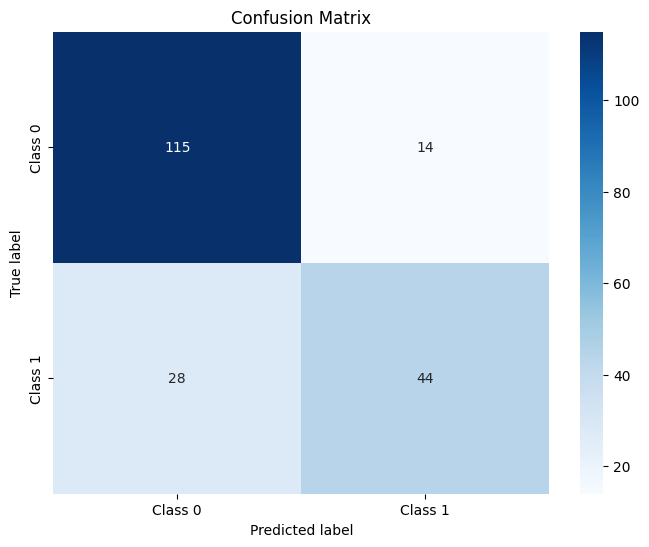

Accuracy: 0.7910447761194029

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.85       129
           1       0.76      0.61      0.68        72

    accuracy                           0.79       201
   macro avg       0.78      0.75      0.76       201
weighted avg       0.79      0.79      0.79       201



In [284]:
# Clean test set
test['cleaned_text'] = test['translated_text'].apply(clean_text)

# Predict on the test set
y_pred_2 = pipeline.predict(test['cleaned_text'])

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_2)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap with the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'],  # Change according to your class labels
            yticklabels=['Class 0', 'Class 1'])

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Print the results
print("Accuracy:", accuracy_score(y_test, y_pred_2))
print("\nClassification Report:\n", classification_report(y_test, y_pred_2))

#print(np.column_stack((y_test[:30], y_pred_1[:30], y_pred_2[:30])))

# Model 3 : TF-IDF and Naive Bayes

In [299]:
from sklearn.feature_extraction.text import TfidfVectorizer

def prepare(data):
  tfidf_vectorizer = TfidfVectorizer(max_features=1000)
  x_matrix = tfidf_vectorizer.fit_transform(data) 
  return x_matrix, tfidf_vectorizer

from sklearn.naive_bayes import MultinomialNB

# Initialize the Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Train the model
X_train_nb, tfidf_vectorizer = prepare(X_train)
nb_model.fit(X_train_nb, y_train)




MultinomialNB()

### Model 3: Results

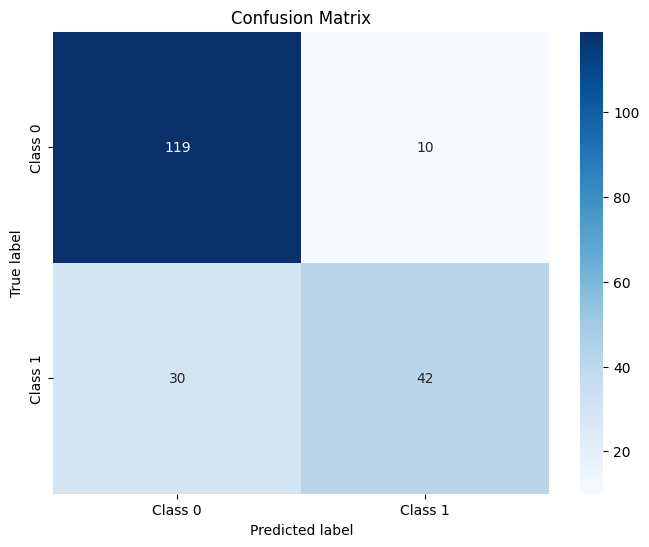

Accuracy: 0.8009950248756219

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.92      0.86       129
           1       0.81      0.58      0.68        72

    accuracy                           0.80       201
   macro avg       0.80      0.75      0.77       201
weighted avg       0.80      0.80      0.79       201



In [300]:
# Run the model on test data
X_test_nb = tfidf_vectorizer.transform(test['cleaned_text'])
y_pred_nb = nb_model.predict(X_test_nb)
y_pred_3 = pd.Series(y_pred_nb)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_3)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap with the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'],  # Change according to your class labels
            yticklabels=['Class 0', 'Class 1'])

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Print the results
print("Accuracy:", accuracy_score(y_test, y_pred_3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_3))

# Converge Overall Results

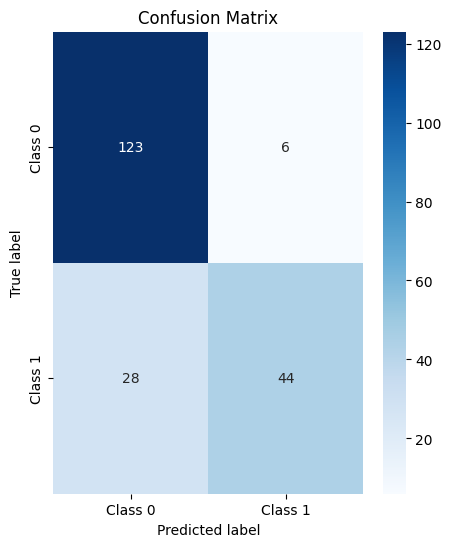

Accuracy: 0.8308457711442786

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.95      0.88       129
           1       0.88      0.61      0.72        72

    accuracy                           0.83       201
   macro avg       0.85      0.78      0.80       201
weighted avg       0.84      0.83      0.82       201



In [301]:
import pandas as pd
from scipy import stats

# Assuming you have three Pandas Series: y_pred_1, y_pred_2, and y_pred_3
# Combine the series into a DataFrame
df_predictions = pd.DataFrame({
    'pred_1': y_pred_1,
    'pred_2': y_pred_2,
    'pred_3': y_pred_3
})

weights = np.array([1,1,1])

# Repeat each prediction according to its weight
weighted_predictions = np.repeat(df_predictions.values, weights, axis=1)

# Apply mode (majority voting) along the rows (axis=1)
final_predictions = stats.mode(weighted_predictions, axis=1)[0].flatten()


# Compute the confusion matrix
cm = confusion_matrix(y_test, final_predictions)

# Set up the matplotlib figure
plt.figure(figsize=(5, 6))

# Create a heatmap with the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'],  # Change according to your class labels
            yticklabels=['Class 0', 'Class 1'])

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Print the results
print("Accuracy:", accuracy_score(y_test, final_predictions))
print("\nClassification Report:\n", classification_report(y_test, final_predictions))